# Lab 7: Cross-lingual Representation Alignment in mBERT

**Paper:** Pires et al. (2019) — *How multilingual is Multilingual BERT?*

**Goal:** Investigate the interlingua hypothesis — do multilingual models learn a shared representation space where parallel sentences in different languages map to similar regions?

**Approach:**
- Extract CLS embeddings from every layer of mBERT for parallel sentences in 3 language pairs
- Compute alignment metrics: cosine similarity, centered kernel alignment (CKA), and nearest neighbor accuracy
- Visualize embedding clusters with UMAP

**Hypotheses:**
1. Embeddings will be most aligned in early layers and alignment will decrease through later layers
2. Typologically related languages (EN-DE) will show higher alignment than distant pairs (EN-RU, EN-FI)

**Language pairs (WMT16):** EN-DE (related, same script), EN-RU (distant, Cyrillic script), EN-FI (distant, same script, Uralic family)

In [ ]:
# If running for the first time, register the experimental conda env as a Jupyter kernel:
# !conda install -n experimental ipykernel -y
# !python -m ipykernel install --user --name experimental --display-name "Python (experimental)"
# Then select "Python (experimental)" as the kernel for this notebook.

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
import umap
from sklearn.manifold import TSNE

sns.set_style("whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 4080 Laptop GPU


## 1. Load Model and Data

We use `bert-base-multilingual-cased` (mBERT) — a 12-layer transformer pre-trained on Wikipedia text from 104 languages with a shared wordpiece vocabulary.

For parallel sentences we use WMT16 (EN-DE, EN-RU, EN-FI) and OPUS-100 (EN-SW). We take 200 parallel sentences from each pair's test split.

In [32]:
# Load mBERT
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()
print(f"Model: {model_name}")
print(f"Layers: {model.config.num_hidden_layers}, Hidden: {model.config.hidden_size}")

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2354.62it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model: bert-base-multilingual-cased
Layers: 12, Hidden: 768


In [33]:
# Load parallel sentences from WMT16
from datasets import load_dataset

N_SENTENCES = 1000

# WMT16 language pairs — each has its own parallel EN side
PAIRS = {
    "EN-DE": {"dataset": "wmt16", "config": "de-en", "src": "en", "tgt": "de"},
    "EN-RU": {"dataset": "wmt16", "config": "ru-en", "src": "en", "tgt": "ru"},
    "EN-FI": {"dataset": "wmt16", "config": "fi-en", "src": "en", "tgt": "fi"},
}

# Store sentence pairs: {pair_name: {"src": [...], "tgt": [...]}}
pair_sentences = {}
for pair_name, info in PAIRS.items():
    ds = load_dataset(info["dataset"], info["config"], split=f"test[:{N_SENTENCES}]")
    pair_sentences[pair_name] = {
        "src": [ex["translation"][info["src"]] for ex in ds],
        "tgt": [ex["translation"][info["tgt"]] for ex in ds],
    }
    print(f"{pair_name}: {len(pair_sentences[pair_name]['src'])} parallel pairs loaded")

# Verify
print("\n--- Sample parallel sentences (index 0) ---")
for pair_name, sents in pair_sentences.items():
    print(f"  {pair_name}:")
    print(f"    EN:  {sents['src'][0][:100]}")
    print(f"    TGT: {sents['tgt'][0][:100]}")

EN-DE: 1000 parallel pairs loaded
EN-RU: 1000 parallel pairs loaded
EN-FI: 1000 parallel pairs loaded

--- Sample parallel sentences (index 0) ---
  EN-DE:
    EN:  Obama receives Netanyahu
    TGT: Obama empfängt Netanyahu
  EN-RU:
    EN:  The social card of residents of Ivanovo region is to be recognised as an electronic payment instrume
    TGT: Социальная карта жителя Ивановской области признается электронным средством платежа.
  EN-FI:
    EN:  A 9-year-old boy missing at Tampere was found
    TGT: Tampereella karkuteillä ollut 9-vuotias poika löytyi


## 2. Embedding Extraction

We extract the **CLS token embedding** at every layer (embedding layer 0 + 12 transformer layers = 13 total). The CLS token (`[CLS]`) is prepended to every input; its hidden state serves as a sentence-level representation.

For each side of each pair, we get a tensor of shape `(200, 13, 768)`.

In [34]:
def get_cls_embeddings_all_layers(texts, model, tokenizer, batch_size=16):
    """Extract CLS embeddings at every layer for a list of sentences.
    
    Returns: tensor of shape (n_sentences, n_layers=13, hidden_dim=768)
    """
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(
            batch, return_tensors="pt", padding=True,
            truncation=True, max_length=128
        ).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        # hidden_states: tuple of 13 tensors, each (batch, seq_len, 768)
        cls_per_layer = torch.stack(
            [hs[:, 0, :] for hs in outputs.hidden_states], dim=1
        )  # (batch, 13, 768)
        all_embeddings.append(cls_per_layer.cpu())
    return torch.cat(all_embeddings, dim=0)

# Extract embeddings for each pair (both src and tgt sides)
pair_embeddings = {}
for pair_name, sents in pair_sentences.items():
    print(f"Embedding {pair_name}...")
    pair_embeddings[pair_name] = {
        "src": get_cls_embeddings_all_layers(sents["src"], model, tokenizer),
        "tgt": get_cls_embeddings_all_layers(sents["tgt"], model, tokenizer),
    }
    print(f"  src: {pair_embeddings[pair_name]['src'].shape}, tgt: {pair_embeddings[pair_name]['tgt'].shape}")

n_layers = pair_embeddings["EN-DE"]["src"].shape[1]
print(f"\nTotal layers (including embedding layer): {n_layers}")

Embedding EN-DE...
  src: torch.Size([1000, 13, 768]), tgt: torch.Size([1000, 13, 768])
Embedding EN-RU...
  src: torch.Size([1000, 13, 768]), tgt: torch.Size([1000, 13, 768])
Embedding EN-FI...
  src: torch.Size([1000, 13, 768]), tgt: torch.Size([1000, 13, 768])

Total layers (including embedding layer): 13


## 3. Layer-wise Cosine Similarity

For each language pair (EN-DE, EN-ZH, EN-SW), we compute the **mean pairwise cosine similarity** between parallel sentence CLS embeddings at each layer.

High cosine similarity means the embeddings point in similar directions — suggesting the model maps parallel sentences to similar regions of the representation space.

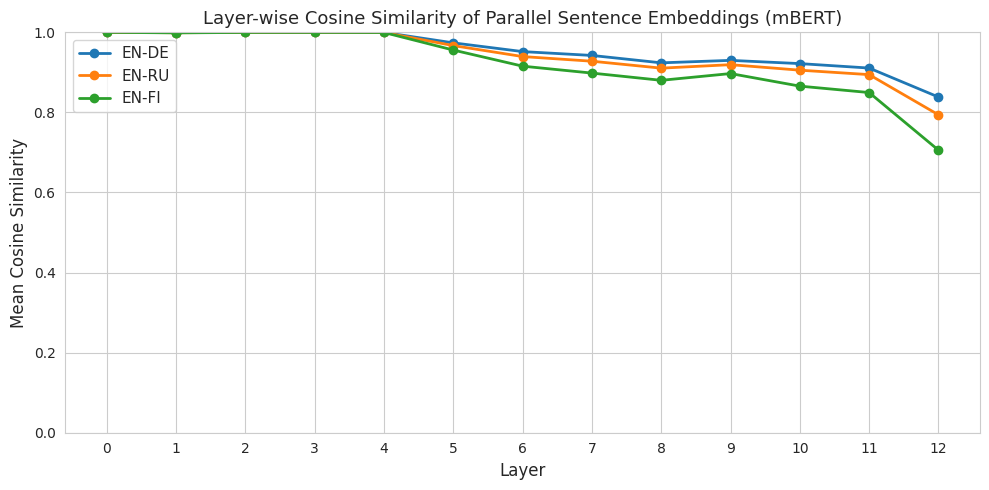


Cosine similarity by layer:
Layer    EN-DE    EN-RU    EN-FI
    0   1.0000   1.0000   1.0000
    1   0.9992   0.9990   0.9987
    2   0.9999   0.9998   0.9997
    3   0.9999   0.9999   0.9998
    4   0.9997   0.9997   0.9996
    5   0.9737   0.9669   0.9557
    6   0.9519   0.9395   0.9155
    7   0.9423   0.9279   0.8982
    8   0.9238   0.9106   0.8802
    9   0.9300   0.9192   0.8970
   10   0.9219   0.9055   0.8656
   11   0.9108   0.8944   0.8496
   12   0.8384   0.7941   0.7058


In [35]:
def compute_layerwise_cosine_sim(emb_a, emb_b):
    """Compute mean cosine similarity between parallel embeddings at each layer.
    
    Args:
        emb_a, emb_b: tensors of shape (n_sentences, n_layers, hidden_dim)
    Returns:
        list of mean cosine similarities, one per layer
    """
    sims = []
    for layer in range(emb_a.shape[1]):
        a = emb_a[:, layer, :]  # (n, 768)
        b = emb_b[:, layer, :]  # (n, 768)
        cos = F.cosine_similarity(a, b, dim=1)  # (n,)
        sims.append(cos.mean().item())
    return sims

# Compute for each language pair
cosine_results = {}
for pair_name, embs in pair_embeddings.items():
    cosine_results[pair_name] = compute_layerwise_cosine_sim(embs["src"], embs["tgt"])

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
for label, sims in cosine_results.items():
    ax.plot(range(n_layers), sims, marker="o", linewidth=2, label=label)
ax.set_xlabel("Layer", fontsize=12)
ax.set_ylabel("Mean Cosine Similarity", fontsize=12)
ax.set_title("Layer-wise Cosine Similarity of Parallel Sentence Embeddings (mBERT)", fontsize=13)
ax.set_xticks(range(n_layers))
ax.legend(fontsize=11)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# Print values
print("\nCosine similarity by layer:")
print(f"{'Layer':>5}", *[f"{l:>8}" for l in cosine_results.keys()])
for i in range(n_layers):
    vals = [cosine_results[l][i] for l in cosine_results]
    print(f"{i:>5}", *[f"{v:>8.4f}" for v in vals])

## 4. Layer-wise Centered Kernel Alignment (CKA)

CKA measures **representational similarity** between two sets of embeddings — it's invariant to orthogonal transformations and isotropic scaling. This means it captures whether two representation spaces encode the *same information*, even if the coordinate systems differ.

$$\text{CKA}(X, Y) = \frac{\|Y^\top X\|_F^2}{\|X^\top X\|_F \cdot \|Y^\top Y\|_F}$$

where $X, Y \in \mathbb{R}^{n \times d}$ are the embedding matrices for two languages at a given layer.

**Note:** Linear CKA has a known positive bias when $n \ll d$ (200 samples, 768 dims), so absolute values will be high even for weakly related representations. We interpret CKA scores **relatively** — comparing across language pairs and layers — rather than reading absolute values.

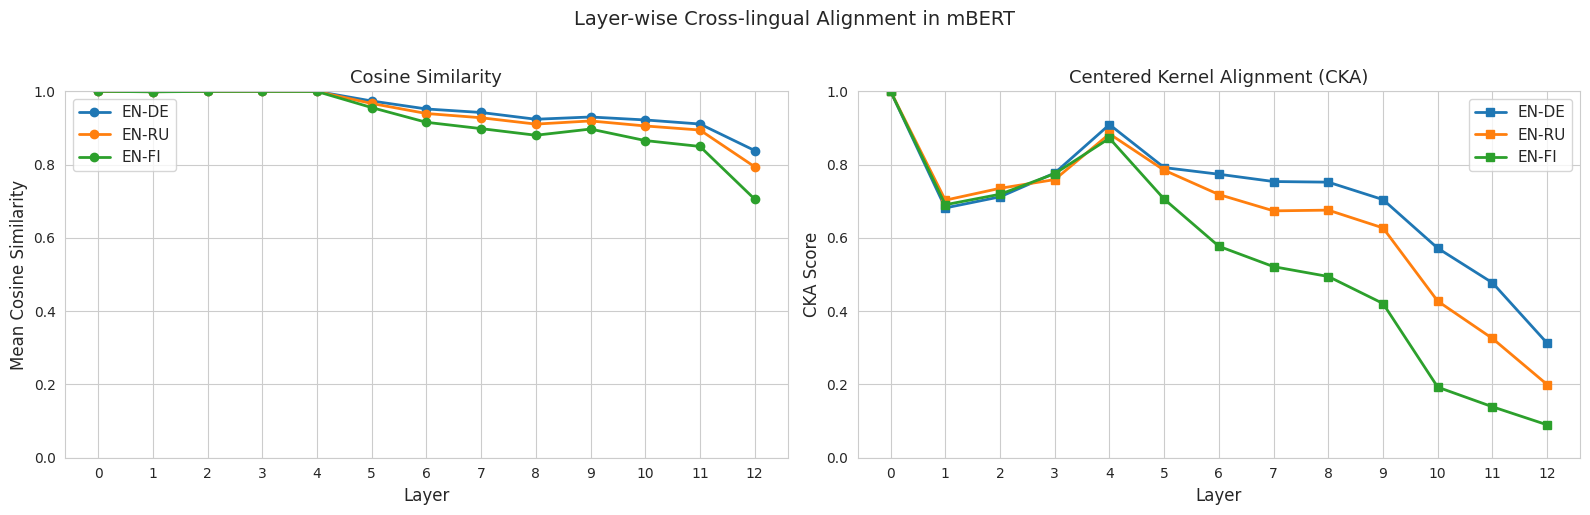


CKA scores by layer:
Layer    EN-DE    EN-RU    EN-FI
    0   1.0000   1.0000   1.0000
    1   0.6817   0.7030   0.6905
    2   0.7120   0.7354   0.7191
    3   0.7770   0.7591   0.7752
    4   0.9093   0.8839   0.8719
    5   0.7919   0.7848   0.7058
    6   0.7737   0.7183   0.5771
    7   0.7538   0.6738   0.5214
    8   0.7521   0.6758   0.4946
    9   0.7045   0.6272   0.4209
   10   0.5718   0.4273   0.1926
   11   0.4774   0.3255   0.1391
   12   0.3126   0.1997   0.0897


In [36]:
def linear_cka(X, Y):
    """Compute linear CKA between two embedding matrices.
    
    Args:
        X, Y: tensors of shape (n_sentences, hidden_dim)
    Returns:
        CKA score (float in [0, 1])
    """
    # Center the embeddings (important for CKA)
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)
    
    hsic_xy = torch.norm(Y.T @ X, p="fro") ** 2
    hsic_xx = torch.norm(X.T @ X, p="fro")
    hsic_yy = torch.norm(Y.T @ Y, p="fro")
    return (hsic_xy / (hsic_xx * hsic_yy)).item()


def compute_layerwise_cka(emb_a, emb_b):
    """Compute CKA at each layer."""
    scores = []
    for layer in range(emb_a.shape[1]):
        a = emb_a[:, layer, :]
        b = emb_b[:, layer, :]
        scores.append(linear_cka(a, b))
    return scores

# Compute CKA for each language pair
cka_results = {}
for pair_name, embs in pair_embeddings.items():
    cka_results[pair_name] = compute_layerwise_cka(embs["src"], embs["tgt"])

# Plot both metrics side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for pair_name in pair_embeddings:
    axes[0].plot(range(n_layers), cosine_results[pair_name], marker="o", linewidth=2, label=pair_name)
    axes[1].plot(range(n_layers), cka_results[pair_name], marker="s", linewidth=2, label=pair_name)

axes[0].set_title("Cosine Similarity", fontsize=13)
axes[1].set_title("Centered Kernel Alignment (CKA)", fontsize=13)
for ax in axes:
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_xticks(range(n_layers))
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1)
axes[0].set_ylabel("Mean Cosine Similarity", fontsize=12)
axes[1].set_ylabel("CKA Score", fontsize=12)

fig.suptitle("Layer-wise Cross-lingual Alignment in mBERT", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print CKA values
print("\nCKA scores by layer:")
print(f"{'Layer':>5}", *[f"{l:>8}" for l in cka_results.keys()])
for i in range(n_layers):
    vals = [cka_results[l][i] for l in cka_results]
    print(f"{i:>5}", *[f"{v:>8.4f}" for v in vals])

## 5. UMAP Visualization

We visualize the CLS embeddings in 2D using UMAP at **every layer** (embedding layer 0 + 12 transformer layers = 13 total).

We use all three language pairs and plot all languages together. **If the interlingua hypothesis holds:** translation pairs should be near each other rather than forming separate language clusters.

Note: Layer 0 structure is a UMAP artifact — CLS embeddings are identical at the embedding layer since `[CLS]` is always the same token at position 0.

/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/expe

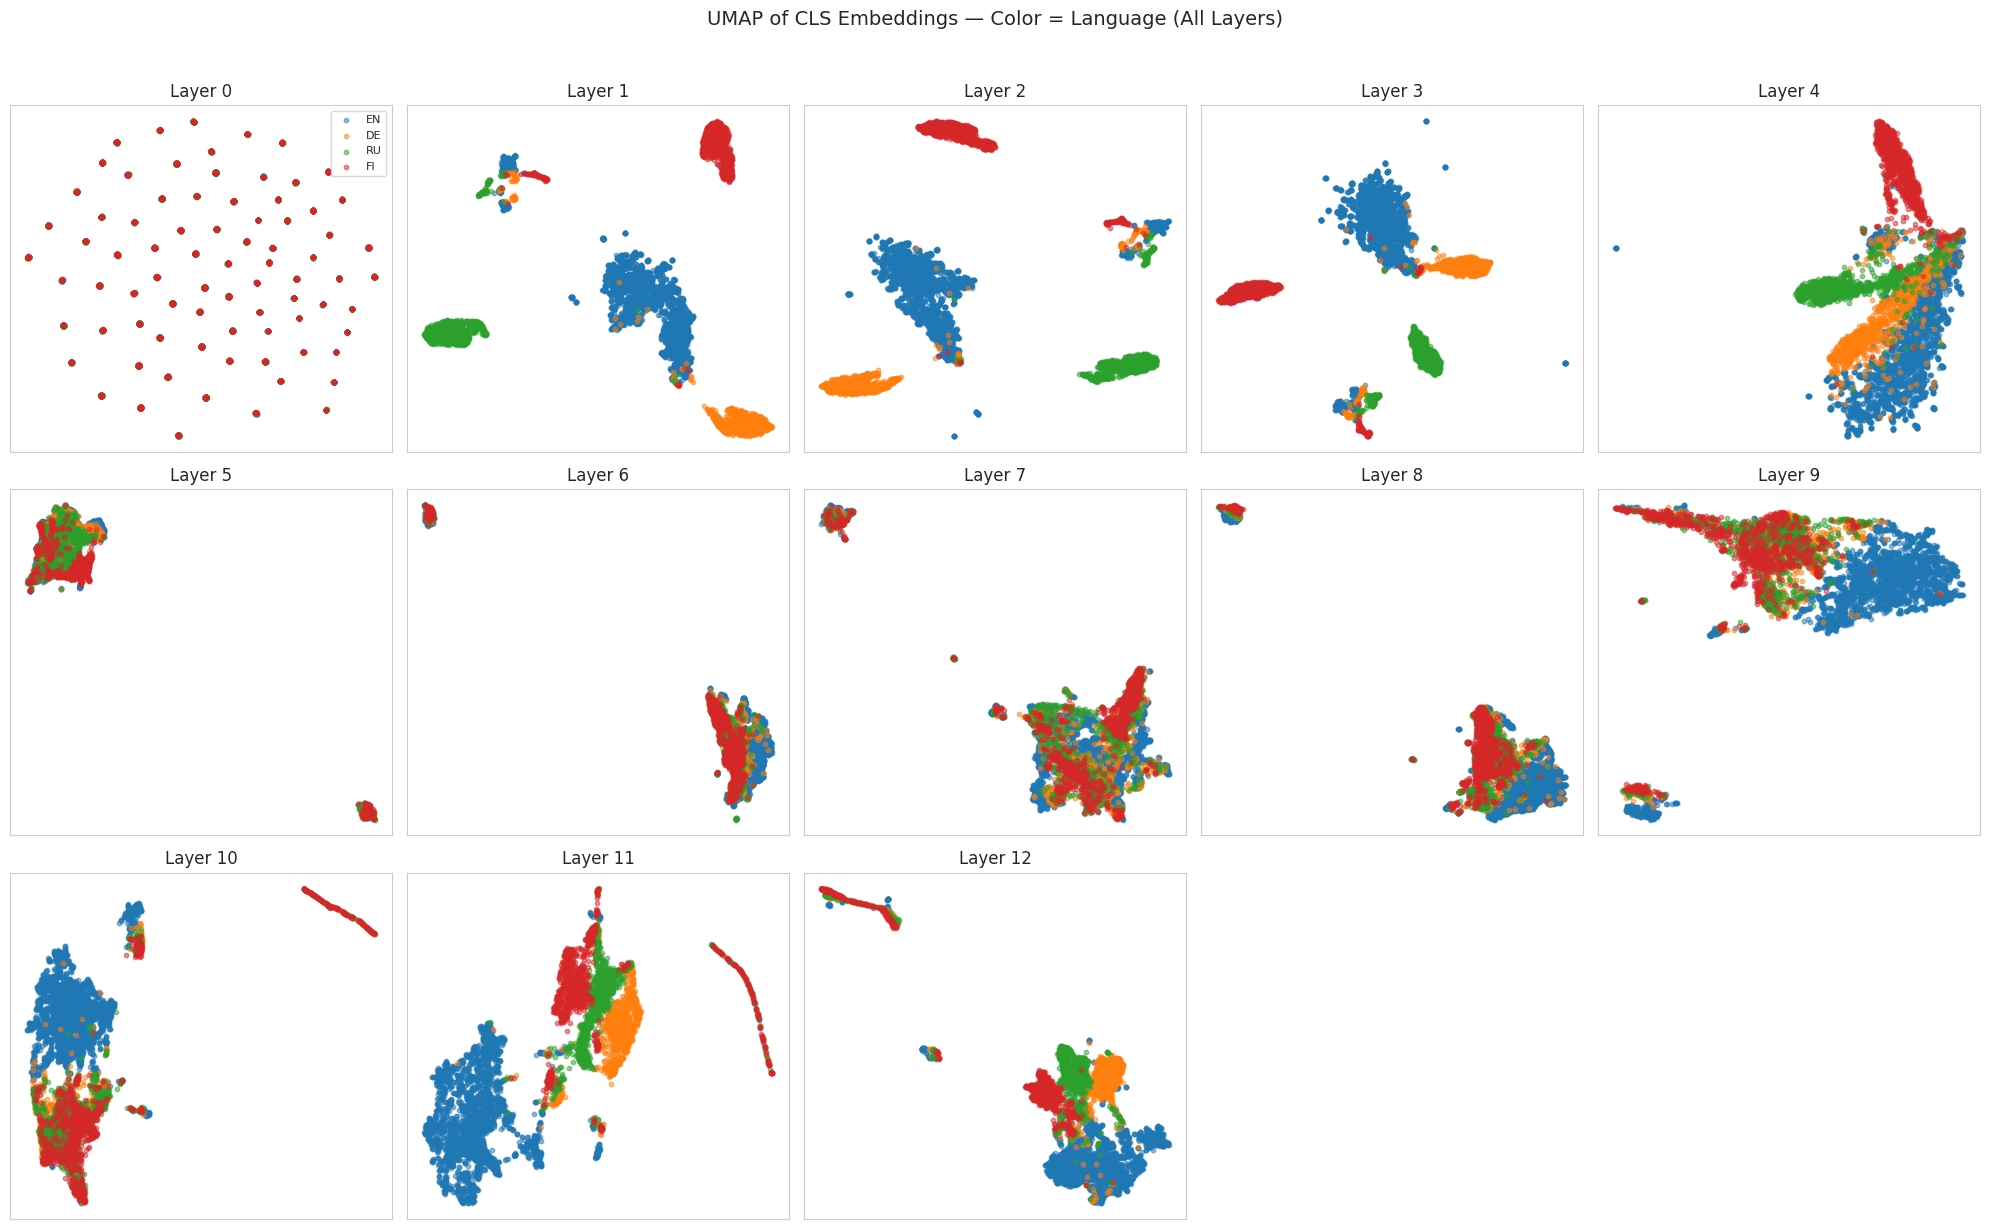

In [37]:
vis_layers = list(range(n_layers))  # All 13 layers
lang_colors = {"EN": "#1f77b4", "DE": "#ff7f0e", "RU": "#2ca02c", "FI": "#d62728"}

# UMAP parameters
UMAP_N_NEIGHBORS = 20
UMAP_MIN_DIST = 0.2

n_cols = 5
n_rows = (len(vis_layers) + n_cols - 1) // n_cols  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, layer in enumerate(vis_layers):
    all_embs = []
    all_labels = []
    for pair_name, embs in pair_embeddings.items():
        tgt_lang = pair_name.split("-")[1]
        all_embs.append(embs["src"][:, layer, :])
        all_embs.append(embs["tgt"][:, layer, :])
        all_labels.extend(["EN"] * N_SENTENCES)
        all_labels.extend([tgt_lang] * N_SENTENCES)

    all_embs = torch.cat(all_embs, dim=0)

    reducer = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=42)
    embs_2d = reducer.fit_transform(all_embs.numpy())

    ax = axes[idx]
    for lang_label, color in lang_colors.items():
        mask = [l == lang_label for l in all_labels]
        if any(mask):
            ax.scatter(
                embs_2d[mask, 0], embs_2d[mask, 1],
                c=color, label=lang_label, alpha=0.5, s=10
            )
    ax.set_title(f"Layer {layer}", fontsize=12)
    if idx == 0:
        ax.legend(fontsize=8, loc="upper right")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused subplot slots
for idx in range(len(vis_layers), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle("UMAP of CLS Embeddings — Color = Language (All Layers)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/experimental/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jay/miniconda3/envs/expe

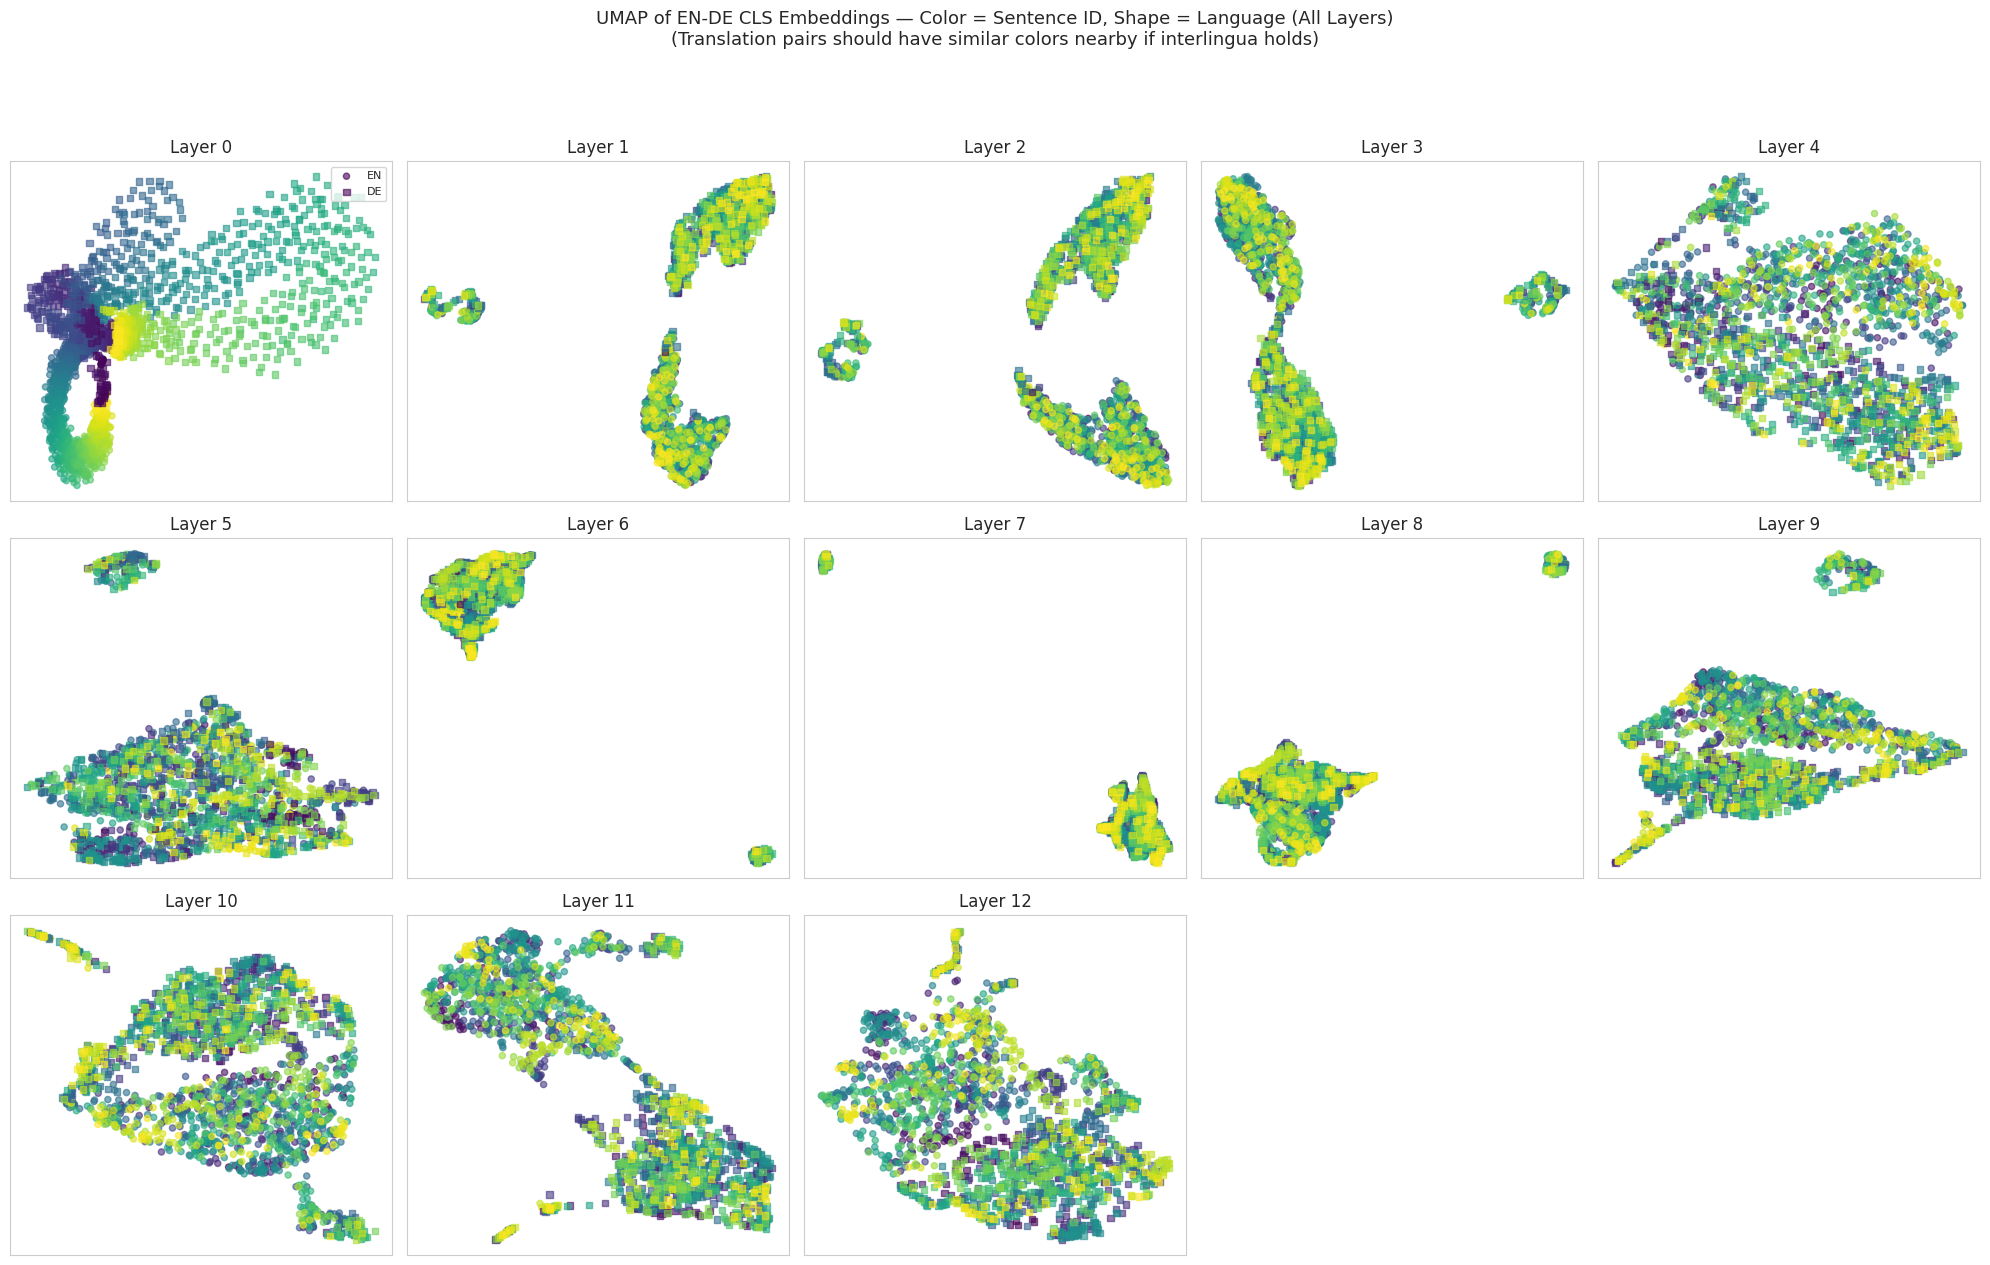

In [38]:
# Focused view: EN-DE pair only, colored by sentence index (all layers)
# If interlingua holds, translation pairs (same color) should cluster together

n_cols = 5
n_rows = (len(vis_layers) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, layer in enumerate(vis_layers):
    en_embs = pair_embeddings["EN-DE"]["src"][:, layer, :]
    de_embs = pair_embeddings["EN-DE"]["tgt"][:, layer, :]
    all_embs = torch.cat([en_embs, de_embs], dim=0)

    reducer = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=42)
    embs_2d = reducer.fit_transform(all_embs.numpy())

    ax = axes[idx]
    sent_ids = np.arange(N_SENTENCES)
    ax.scatter(embs_2d[:N_SENTENCES, 0], embs_2d[:N_SENTENCES, 1],
               c=sent_ids, cmap="viridis", marker="o", alpha=0.6, s=20, label="EN")
    ax.scatter(embs_2d[N_SENTENCES:, 0], embs_2d[N_SENTENCES:, 1],
               c=sent_ids, cmap="viridis", marker="s", alpha=0.6, s=20, label="DE")
    ax.set_title(f"Layer {layer}", fontsize=12)
    if idx == 0:
        ax.legend(fontsize=8, loc="upper right")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused subplot slots
for idx in range(len(vis_layers), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle(
    "UMAP of EN-DE CLS Embeddings — Color = Sentence ID, Shape = Language (All Layers)\n"
    "(Translation pairs should have similar colors nearby if interlingua holds)",
    fontsize=13, y=1.05
)
plt.tight_layout()
plt.show()

## 6. Mutual Nearest Neighbor Accuracy

As an additional alignment metric (following Pires et al.'s approach in Section 5), for each English sentence we find its nearest neighbor in the target language's embedding space and check if it's the correct translation. This mimics a retrieval task.

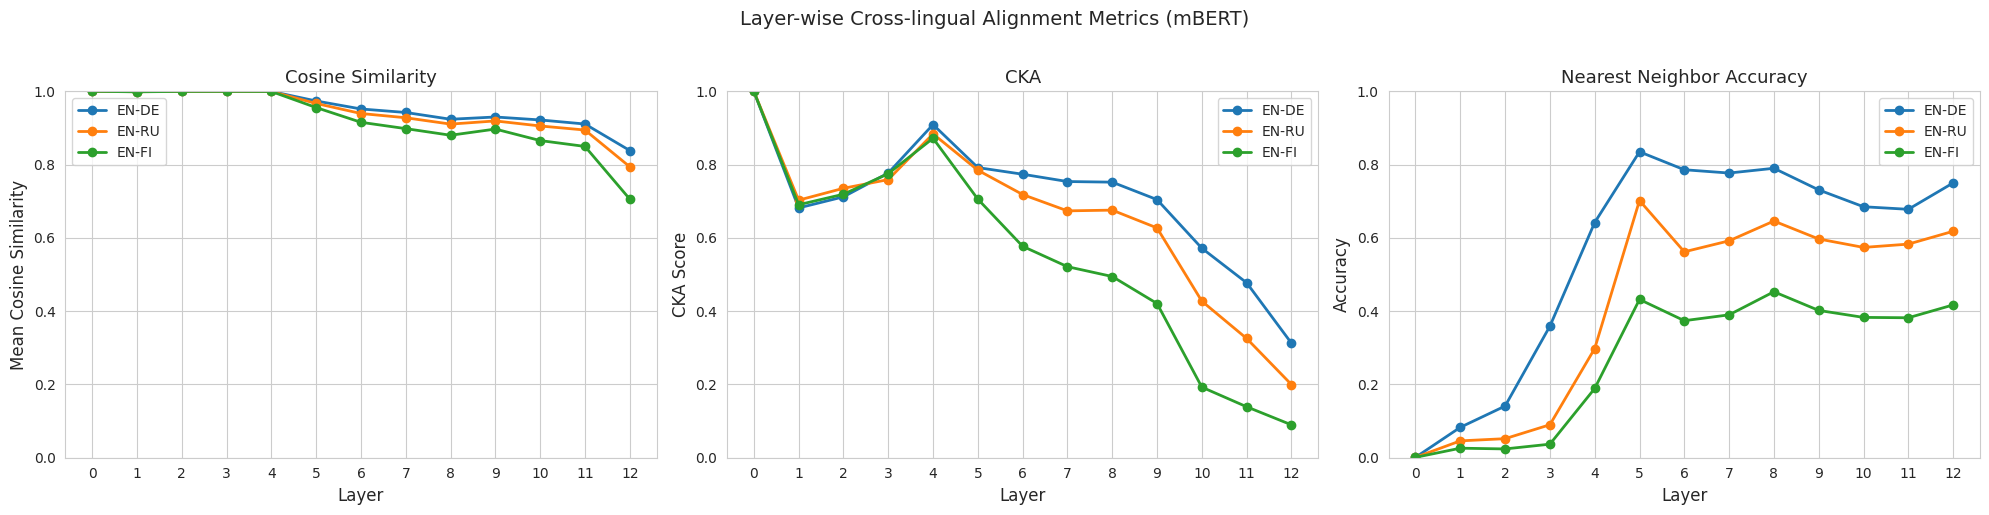


Nearest Neighbor Accuracy by layer:
Layer    EN-DE    EN-RU    EN-FI
    0    0.10%    0.10%    0.10%
    1    8.30%    4.60%    2.60%
    2   14.10%    5.20%    2.40%
    3   35.90%    9.00%    3.70%
    4   64.20%   29.80%   18.90%
    5   83.50%   70.20%   43.20%
    6   78.60%   56.20%   37.40%
    7   77.70%   59.20%   39.00%
    8   79.00%   64.60%   45.30%
    9   73.10%   59.70%   40.20%
   10   68.50%   57.40%   38.30%
   11   67.80%   58.30%   38.20%
   12   75.00%   61.80%   41.70%


In [39]:
def mutual_nn_accuracy(emb_a, emb_b):
    """Fraction of sentences where the nearest neighbor is the correct translation."""
    a_norm = F.normalize(emb_a, dim=1)
    b_norm = F.normalize(emb_b, dim=1)
    sim_matrix = a_norm @ b_norm.T
    preds = sim_matrix.argmax(dim=1)
    correct = (preds == torch.arange(len(preds))).float().mean().item()
    return correct


def compute_layerwise_nn_acc(emb_a, emb_b):
    """Compute nearest-neighbor retrieval accuracy at each layer."""
    accs = []
    for layer in range(emb_a.shape[1]):
        a = emb_a[:, layer, :]
        b = emb_b[:, layer, :]
        accs.append(mutual_nn_accuracy(a, b))
    return accs

# Compute for each pair
nn_results = {}
for pair_name, embs in pair_embeddings.items():
    nn_results[pair_name] = compute_layerwise_nn_acc(embs["src"], embs["tgt"])

# Plot all three metrics
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
titles = ["Cosine Similarity", "CKA", "Nearest Neighbor Accuracy"]
results_list = [cosine_results, cka_results, nn_results]
ylabels = ["Mean Cosine Similarity", "CKA Score", "Accuracy"]

for ax, title, results, ylabel in zip(axes, titles, results_list, ylabels):
    for pair_name in pair_embeddings:
        ax.plot(range(n_layers), results[pair_name], marker="o", linewidth=2, label=pair_name)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(range(n_layers))
    ax.legend(fontsize=10)
    ax.set_ylim(0, 1)

fig.suptitle("Layer-wise Cross-lingual Alignment Metrics (mBERT)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print NN accuracy values
print("\nNearest Neighbor Accuracy by layer:")
print(f"{'Layer':>5}", *[f"{l:>8}" for l in nn_results.keys()])
for i in range(n_layers):
    vals = [nn_results[l][i] for l in nn_results]
    print(f"{i:>5}", *[f"{v:>8.2%}" for v in vals])

## 7. Results Summary and Hypothesis Evaluation

In [ ]:
# Summary table: peak layer and peak value for each metric and pair
print("=" * 75)
print("SUMMARY: Peak alignment by metric and language pair")
print("=" * 75)
print(f"{'Metric':<12} {'Pair':<8} {'Peak Layer':>10} {'Peak Value':>12} {'Final (L12)':>12}")
print("-" * 75)

for metric_name, results in [("Cosine", cosine_results), ("CKA", cka_results), ("NN Acc.", nn_results)]:
    for pair_name in pair_embeddings:
        vals = results[pair_name]
        peak_layer = int(np.argmax(vals))
        peak_val = max(vals)
        final_val = vals[-1]
        fmt = ".2%" if metric_name == "NN Acc." else ".4f"
        print(f"{metric_name:<12} {pair_name:<8} {peak_layer:>10} {peak_val:>12{fmt}} {final_val:>12{fmt}}")
    print()

print("=" * 75)
print("\nHYPOTHESIS EVALUATION:")
print("\n1. 'Alignment decreases through later layers':")
for pair_name in pair_embeddings:
    peak = int(np.argmax(cosine_results[pair_name]))
    final = cosine_results[pair_name][-1]
    early = cosine_results[pair_name][0]
    print(f"   {pair_name}: Peak cosine at layer {peak}, early (L0)={early:.4f}, final (L12)={final:.4f}")

print("\n2. 'More distant languages show different alignment patterns':")
for metric_name, results in [("Cosine", cosine_results), ("CKA", cka_results), ("NN Acc.", nn_results)]:
    avgs = {p: np.mean(results[p]) for p in pair_embeddings}
    print(f"   {metric_name} avg — " + ", ".join(f"{p}: {v:.4f}" for p, v in avgs.items()))
print("\n   EN-DE (related, same script) vs EN-RU (distant, different script) vs EN-FI (distant, same script)")